In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0

## ProTEM

In [7]:
# For example, line 4 in the data file would be parsed as:
from pathlib import Path

file_name = Path('data')/'lab1_protem.txt'
with open(file_name, 'r') as f:
    lines = f.readlines()

## Reading in data

In [22]:
# First going to associate the correct current with each data record
# by looking for the headers
data_lines = []
for line in lines:
    if "HEADER" in line:
        hdr_line = line.split()
        current = float(hdr_line[3])
        to_time = float(hdr_line[4])
        tx_sizes = (float(hdr_line[5]), float(hdr_line[6]))
        rx_area = float(hdr_line[7])
    else:
        record_line = line
        line_number  = record_line[0:6]
        station_number = record_line[7:13]
        component = record_line[13]
        frequency_key = record_line[15]
        gain = int(record_line[17])
        syncmode = record_line[18]
        primary_field = float(record_line[20:27])
        voltages = record_line[27:27+20*7]
        # Then split them up (and convert them to floats)
        # using a fixed width...
        voltages = np.array([voltages[7*i:7*(i+1)] for i in range(20)], dtype=float)
        data_lines.append([station_number, component, frequency_key, gain, current, voltages])

In [30]:
# Good H data correspond to data lines 
H_data = data_lines[3:3*5+3]
#H_data
u_data = data_lines[-17:-2]

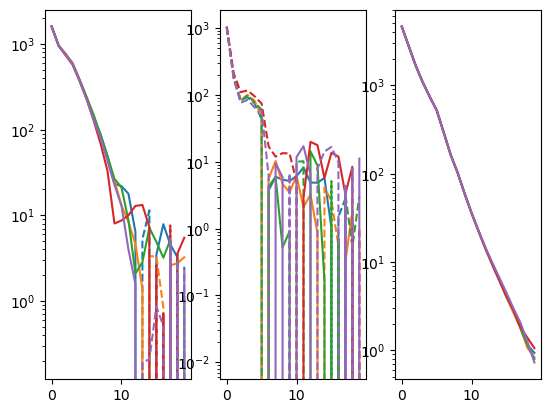

In [37]:
fig, axs = plt.subplots(1,3)
x_count = 0
y_count = 0
z_count = 0
for dat_line in H_data:
    comp = dat_line[1]
    if comp == 'X':
        ax = axs[0]
        count = x_count
        x_count += 1
    elif comp == 'Y':
        ax = axs[1]
        count = y_count
        y_count += 1
    else:
        ax = axs[2]
        count = z_count
        z_count += 1
    volts = dat_line[-1]
    ax.semilogy(volts, color=f'C{count}', linestyle='-')
    ax.semilogy(-volts, color=f'C{count}', linestyle='--')

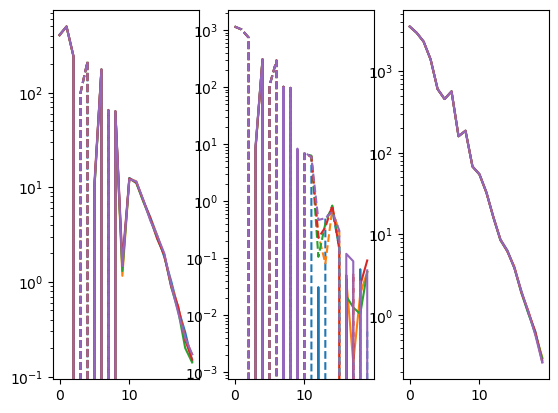

In [38]:
fig, axs = plt.subplots(1,3)
x_count = 0
y_count = 0
z_count = 0
for dat_line in u_data:
    comp = dat_line[1]
    if comp == 'X':
        ax = axs[0]
        count = x_count
        x_count += 1
    elif comp == 'Y':
        ax = axs[1]
        count = y_count
        y_count += 1
    else:
        ax = axs[2]
        count = z_count
        z_count += 1
    volts = dat_line[-1]
    ax.semilogy(volts, color=f'C{count}', linestyle='-')
    ax.semilogy(-volts, color=f'C{count}', linestyle='--')

### get U and H data into V/(m**2 * A)
* Assign times to each
* Normalize by currents and gains and rx_area

In [93]:
def normalize_voltages(volts, current, gain, rx_area):
    # Returns in nV/(m**2 * amps)
    return volts/(2**gain * current * rx_area) * 19.2 * 1000

In [94]:
norm_H_volts = []
for dat_line in H_data:
    current = dat_line[-2]
    gain = dat_line[-3]
    rx_area = 31.4
    volts = dat_line[-1]
    norm_H_volts.append(normalize_voltages(volts, current, gain, rx_area))
norm_H_volts = np.asarray(norm_H_volts)*1E-9

In [95]:
norm_u_volts = []
for dat_line in u_data:
    current = dat_line[-2]
    gain = dat_line[-3]
    rx_area = 31.4
    volts = dat_line[-1]
    norm_u_volts.append(normalize_voltages(volts, current, gain, rx_area))
norm_u_volts = np.asarray(norm_u_volts)*1E-9

In [96]:
# station_number, component, frequency_key, gain, current, voltages

In [97]:
u20Centers = np.array([6.813,8.688,11.13,14.19,18.07,23.06,29.44,
      37.56,47.94,61.13,77.94,99.38,126.7,166.4,206,262.8,
      335.2,427.7,545.6,695.9])

In [98]:
H20Centers = np.array([88.125,106.875,131.25,161.875,200.625,250.625,
      314.375,395.625,499.375,631.25,799.375,1013.75,1286.875,
      1635.625,2080.625,2648.125,3372.5,4296.875,5475.5,6978.5])

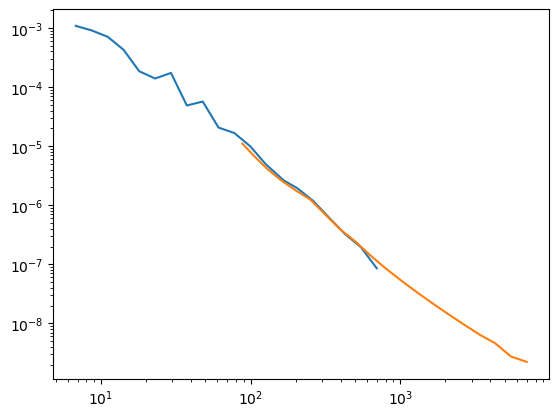

In [99]:
plt.loglog(u20Centers, norm_u_volts[0])
plt.loglog(H20Centers, norm_H_volts[0])

In [100]:
def app_cond_late_time(v, t, moment):
    temp = v**2 * t**5 / (moment**2 * mu_0**5) * 20**2
    return temp**(1/3) * np.pi

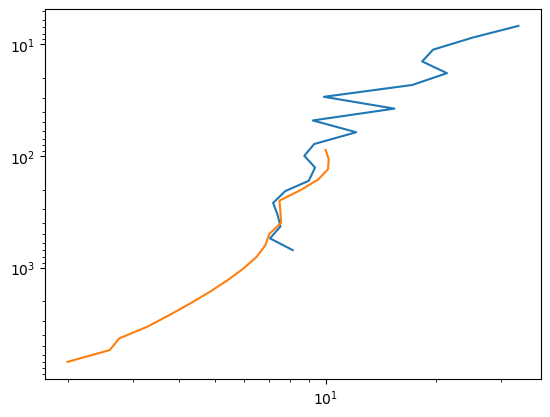

In [109]:
t = u20Centers
sigma_a = app_cond_late_time(norm_u_volts[0], t*1E-6, 40 * 40)
plt.loglog(1/sigma_a, t)

t = H20Centers
sigma_a = app_cond_late_time(norm_H_volts[0], t*1E-6, 40 * 40)
plt.loglog(1/sigma_a, t)
plt.gca().invert_yaxis()

## WalkTEM

In [112]:
walk_data_file = Path('data')/'lab1_walktem.txt'
with open(walk_data_file) as f:
    data_lines = f.readlines()

walk_tem_centers = [float(time) for time in data_lines[1].split()]
n_gates = len(walk_tem_centers)
n_gates

46

In [141]:
# separate data by receiver and moment
walk_data = {}

# Channel 0 is on lines 4 through 87 in the data file
ch0_moment1 = []
ch0_moment2 = []
for line in data_lines[3:87]:
    line_split = line.split()
    current = float(line_split[2])
    moment_id = int(line_split[8])  # 1 for high moment 2 for low moment
    volts = np.array([float(dat) for dat in line_split[9:]])
    datline = [current, volts]
    if moment_id == 1:
        ch0_moment1.append(datline)
    else:
        ch0_moment2.append(datline)

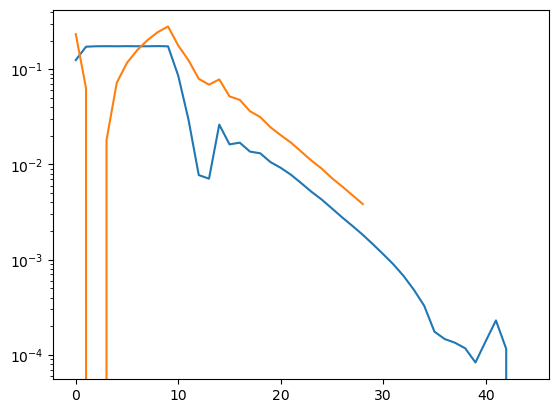

In [142]:
plt.semilogy(-ch0_moment1[0][1]/ch0_moment1[0][0])
plt.semilogy(-ch0_moment2[0][1]/ch0_moment2[0][0])

In [143]:
# Channel 0 is on lines 4 through 87 in the data file
ch1_moment1 = []
ch1_moment2 = []
for line in data_lines[88:]:
    line_split = line.split()
    current = float(line_split[2])
    moment_id = int(line_split[8])  # 1 for high moment 2 for low moment
    volts = np.array([float(dat) for dat in line_split[9:]])
    datline = [current, volts]
    if moment_id == 1:
        ch1_moment1.append(datline)
    elif moment_id == 2:
        ch1_moment2.append(datline)

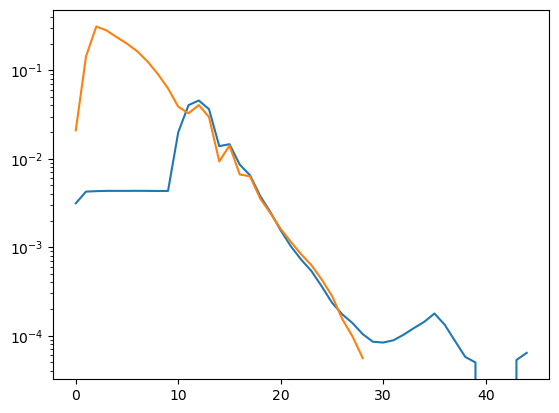

In [144]:
plt.semilogy(-ch1_moment1[0][1]/ch1_moment1[0][0])
plt.semilogy(-ch1_moment2[0][1]/ch1_moment2[0][0])